<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/410_reglin_3.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(reglin-pymc-notebook)=
# Analisi bayesiana del modello di regressione lineare

In questo capitolo, affronteremo l'analisi bayesiana del modello di regressione lineare. In un contesto bayesiano, il modello di regressione lineare è formulato in questo modo:

$$
\begin{align}
y_i  & \sim \mathcal{N}(\mu_i, \sigma)\\\notag
\mu_i & = \alpha + \beta X
\end{align}
$$

dove $y_i$ l'output da prevedere (o variabile dipendente) e $x_i$ il predittore (o variabile indipendente). Il modello assume che $y_i$ sia distribuito secondo una distribuzione normale $\mathcal{N}(\mu_i, \sigma)$, dove $\mu_i$ è la media e $\sigma$ rappresenta l'errore di osservazione. La relazione tra $\mu_i$ (il valore atteso di $y_i$) e $x_i$ è espressa come una funzione lineare: $\mu_i = \alpha + \beta x_i$, dove $\alpha$ è l'intercetta e $\beta$ è la pendenza. 

L'approccio bayesiano al modello di regressione lineare ci permette di specificare distribuzioni a priori per i parametri del modello, ossia $\alpha$, $\beta$ e $\sigma$. Successivamente, utilizzando i dati osservati, possiamo ottenere la distribuzione a posteriori dei parametri, che ci consente di valutare l'incertezza nella stima di $\alpha$ e $\beta$.

## Regressione lineare con PyMC

Per costruire il modello lineare con PyMC, iniziamo importando i moduli necessari.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import bambi as bmb
import arviz as az
import xarray as xr
import warnings
from pymc import HalfCauchy, Model, Normal, sample

warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Simulazione

In questo esempio, procederemo a simulare dei dati per valutare l'efficacia di un modello di regressione lineare bayesiano. Il nostro modello ipotizza che la variabile dipendente $y$ segua una distribuzione normale con una media data dal predittore lineare $\alpha + \beta x$, dove $\alpha$ e $\beta$ sono i parametri del modello, e una specifica varianza $\sigma^2$.

Per generare i dati artificiali, useremo il modulo `random` di `NumPy`. Una volta ottenuti i dati, utilizzeremo PyMC per condurre un'analisi bayesiana al fine di stimare i valori dei parametri $\alpha$, $\beta$, e $\sigma^2$. Confrontando questi risultati con i valori "veri" utilizzati per generare i dati, saremo in grado di valutare quanto il nostro modello sia in grado di approssimare il processo generativo sottostante dei dati.

In sostanza, questo approccio ci consentirà di verificare l'accuratezza del nostro modello di regressione lineare bayesiano e di capire quanto bene riesce a catturare i veri rapporti tra le variabili coinvolte.

In [6]:
# True parameter values
alpha = 1 
beta = 1.5
sigma = 2.0

# Size of dataset
size = 100

# Predictor variable
X = rng.normal(size=size)

# Simulate outcome variable
Y = alpha + beta * X + rng.normal(size=size) * sigma

df = pd.DataFrame({"x": X, "y": Y})
df.head()

,x,y
0,-0.989121,-1.515217
1,-0.367787,3.764547
2,1.287925,2.337363
3,0.193974,-1.475793
4,0.920231,1.817937


Visualizziamo i dati simulati mediante un diagramma a dispersione che include la retta dei minimi quadrati.

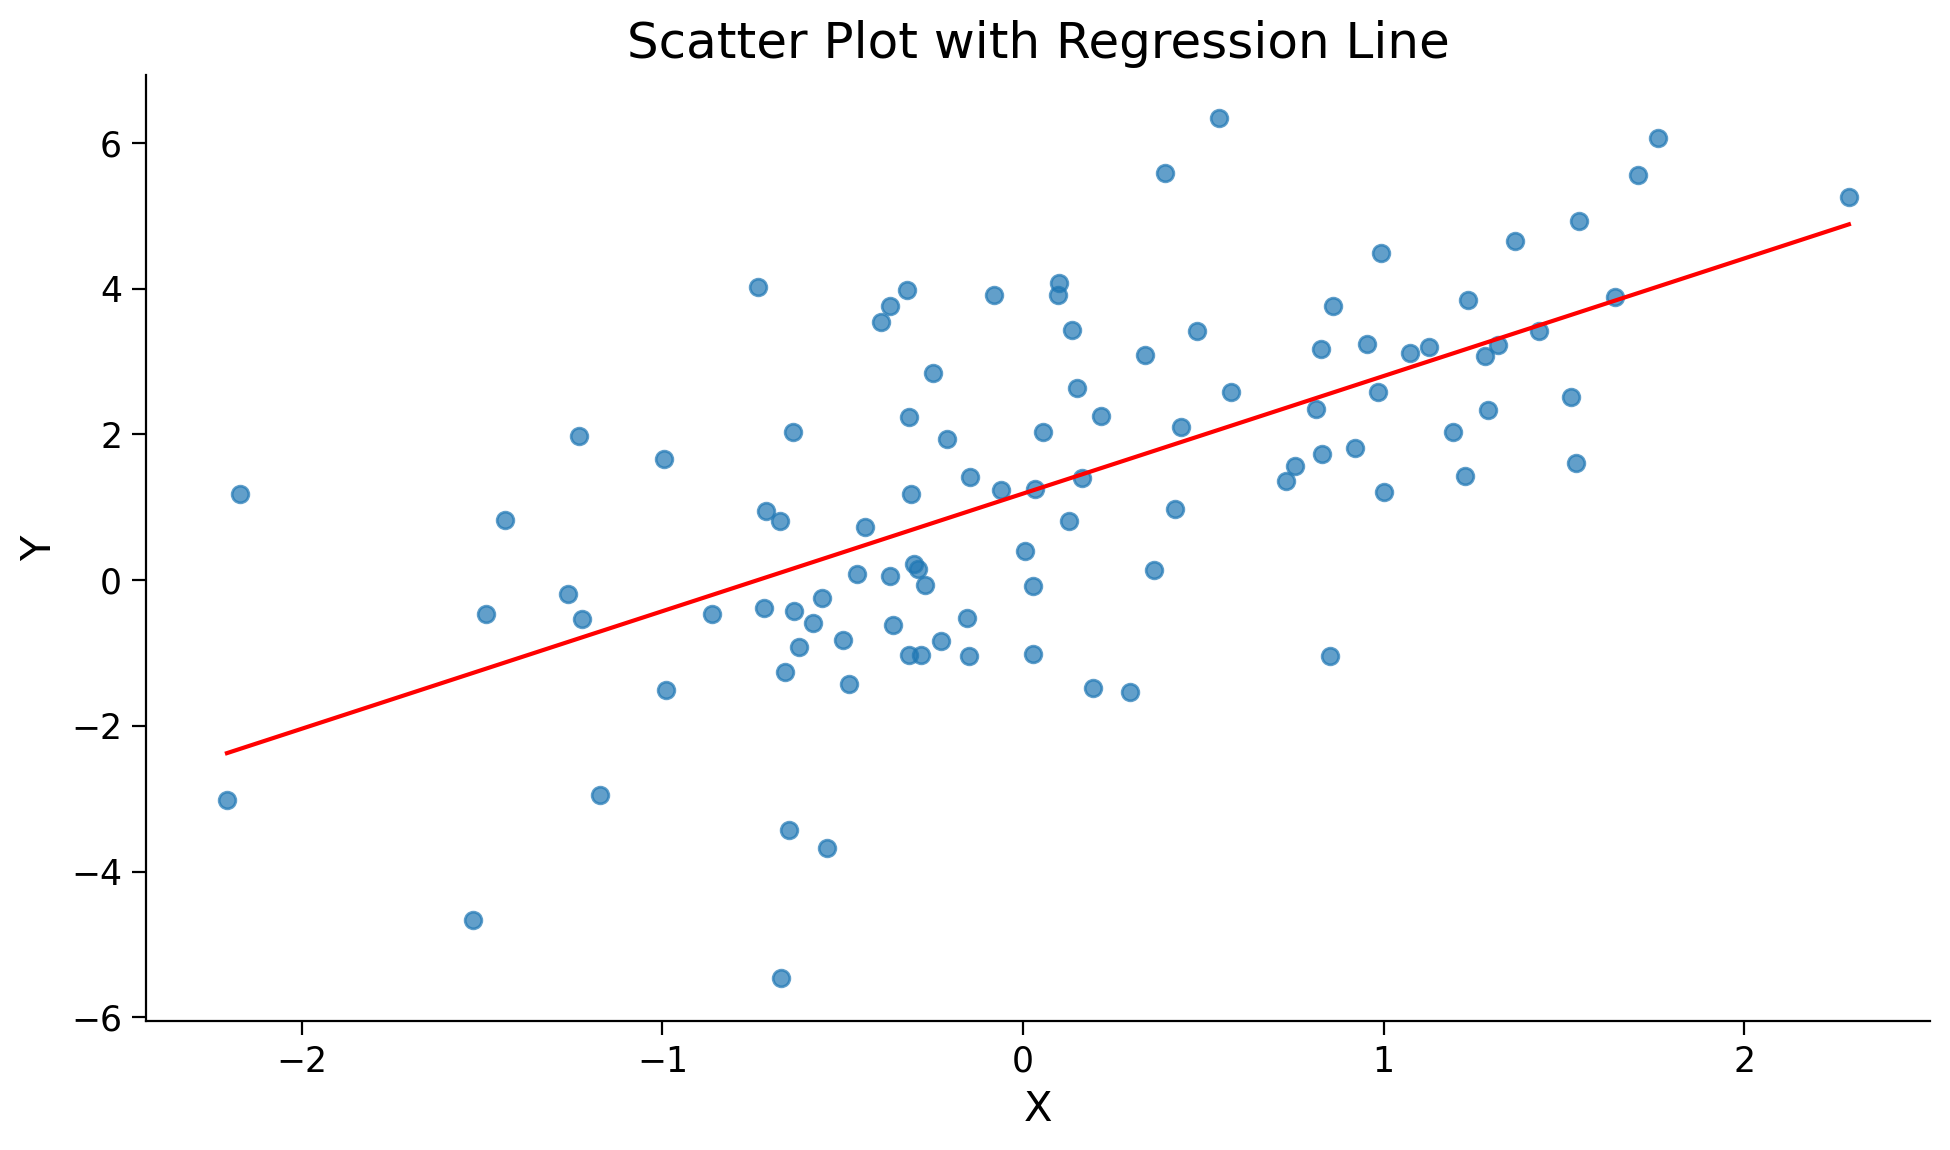

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df["x"], df["y"], alpha=0.7)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with Regression Line")
plt.plot(np.unique(df["x"]), np.poly1d(np.polyfit(df["x"], df["y"], 1))(np.unique(df["x"])), color="red");

## Distribuzioni a priori

Poiché stiamo costruendo un modello di regressione lineare bayesiana, dobbiamo specificare le distribuzioni a priori per le variabili del modello che non conosciamo. In questo caso, scegliamo di assegnare distribuzioni normali a media zero e varianza di 2 ai coefficienti di regressione $\alpha$ e $\beta$, che rappresentano le nostre conoscenze iniziali circa i possibili valori dei parametri. Questa scelta riflette un atteggiamento neutrale o debolmente informativo rispetto ai parametri, fornendo solo un'informazione limitata sulla loro possibile distribuzione.

Per la varianza dell'errore di osservazione $\sigma^2$, scegliamo una distribuzione di Cauchy troncata, limitata a zero, di parametro 5. Questa scelta riflette l'idea che la varianza sia una quantità positiva, il che impedisce alla distribuzione di attribuire probabilità a valori negativi. 

$$
\begin{align}
\alpha &\sim \mathcal{N}(0, 2)\notag\\
\beta &\sim \mathcal{N}(0, 2)\notag\\
\sigma &\sim \mid\text{Cauchy}(5) \mid\notag
\end{align}
$$


## Specificazione del modello

Definiamo ora il modello di regressione lineare bayesiano utilizzando PyMC. Successivamente, eseguiamo l'analisi bayesiana per ottenere la distribuzione a posteriori dei parametri.

In [6]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    
    # Define priors
    sigma = HalfCauchy("sigma", beta=5)
    alpha = Normal("alpha", 0, sigma=2)
    beta = Normal("beta", 0, sigma=2)

    # Define likelihood
    likelihood = Normal("y", mu=alpha + beta * df["x"], sigma=sigma, observed=df["y"])

    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 19 seconds.


La funzione `sample` utilizza l'algoritmo NUTS (di default) per eseguire il campionamento della distribuzione a posteriori dei parametri del modello. Viene specificato un numero di iterazioni e `sample` restituisce un oggetto `InferenceData` che contiene i campioni raccolti dalle catene parallele generate dall'algoritmo di campionamento, insieme ad altri attributi. Si noti che il numero di catene parallele generate dipende dal numero di core di calcolo disponibili sulla macchina.

Diamo una rapida occhiata al modello che abbiamo appena stimato utilizzando il metodo `model_to_graphviz`.

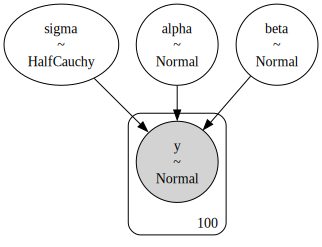

In [7]:
pm.model_to_graphviz(model)

Nel processo di costruzione del modello, abbiamo stabilito alcune ipotesi che meritano di essere evidenziate. La prima ipotesi afferma che, condizionatamente a $X$, i dati $y$ sono indipendenti; la seconda afferma che il valore atteso di $Y$ è una funzione lineare di $X$; la terza ipotesi stabilisce che, condizionatamente a $X_i$, la variabile $Y$ si distribuisce normalmente attorno al suo valore atteso con una deviazione standard $\sigma$, la quale risulta essere costante per $i \in 1, ..., n$. Queste tre ipotesi costituiscono la base della regressione normale bayesiana.

## Interpretare i risultati della regressione bayesiana

La collezione di campioni generati dalla distribuzione a posteriori costituisce una "traccia", che viene restituita dalla funzione `pm.sample`. Esaminiamo più da vicino questa traccia:

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Si noti che ci sono 4 catene, ciascuna formata da 2000 elementi, per ciascuno dei tre parametri ($\alpha$, $\beta$, $\sigma$)

L'oggetto `InferenceData` restituito dal metodo `pm.sample` contiene vari attributi che possono essere esaminati come un `dict` di `numpy.arrays`. Ad esempio, per vedere i primi 5 valori della variabile `alpha` in ogni catena, è possibile utilizzare il seguente codice:

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.30088772, 1.06886368, 1.2332862 , 1.05828676, 1.52046104],
       [0.87271344, 1.00828226, 0.9666113 , 1.01377324, 1.1023033 ],
       [1.17975346, 1.18043653, 1.1613984 , 1.12249269, 1.30459182],
       [1.21341725, 1.11427975, 1.25205419, 1.25205419, 1.11856987]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

Per analizzare la distribuzione a posteriori in un modo più semplice, possiamo utilizzare le funzioni del modulo `Arviz`. In particolare, possiamo creare un trace plot utilizzando la funzione `plot_trace`. Il trace plot è un grafico che rappresenta l'andamento della catena di Markov per ciascun parametro e per ciascuna catena parallela. È uno strumento utile per valutare la convergenza della catena al valore stazionario e per verificare l'indipendenza delle catene tra loro. In particolare, il plot ci permette di valutare se la catena esplora adeguatamente lo spazio dei parametri e se raggiunge un equilibrio tra la ricerca di nuove regioni e l'esplorazione delle regioni già visitate. Inoltre, il plot ci consente di valutare la presenza di autocorrelazione tra le iterazioni della catena, che può indicare una convergenza lenta o una convergenza a un valore sub-ottimale.

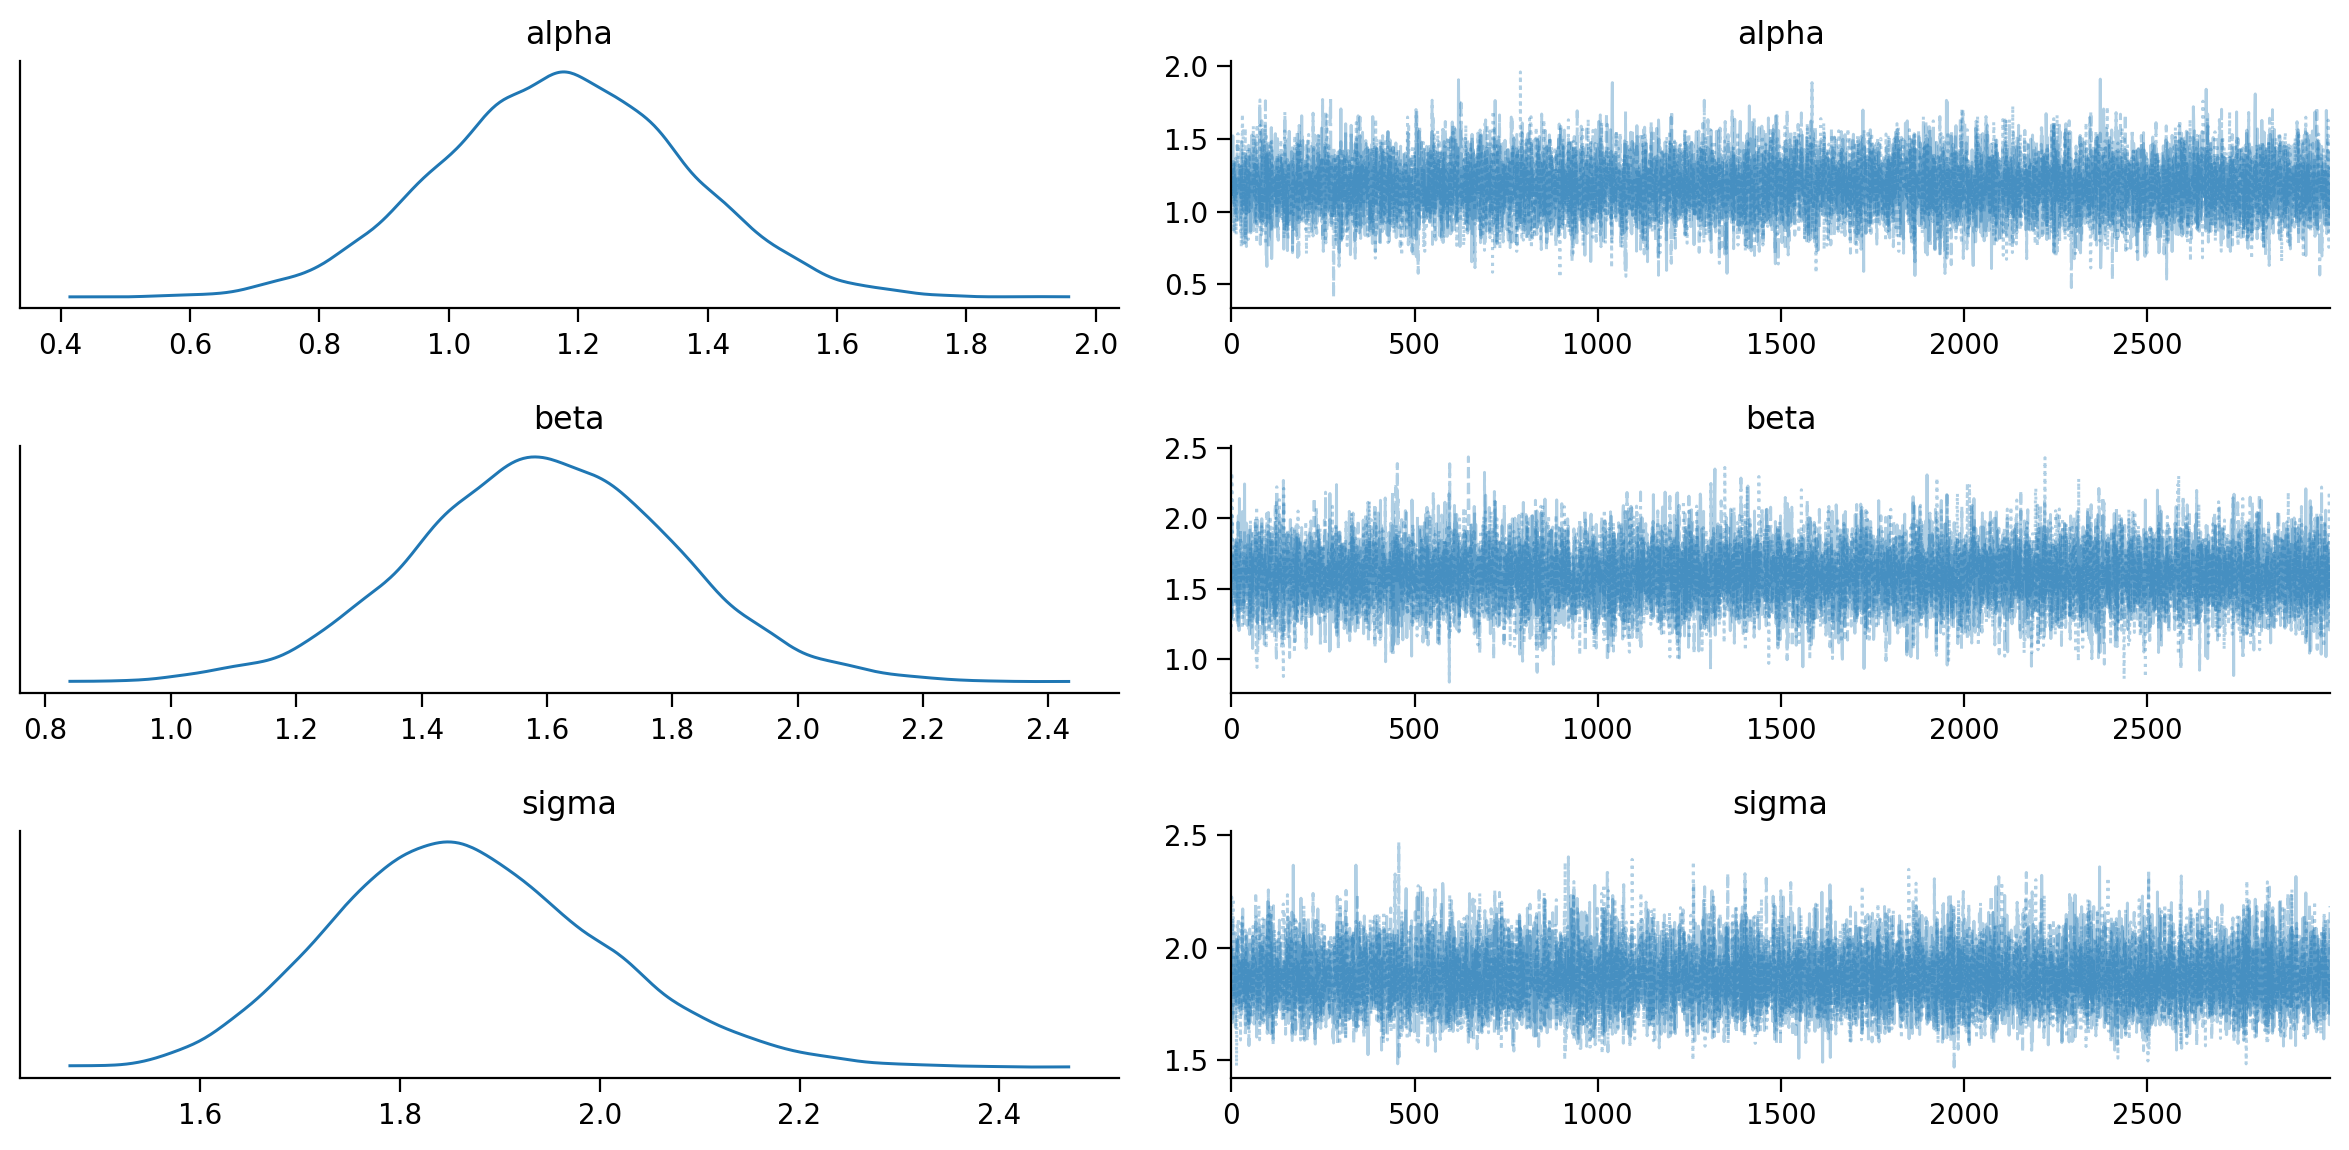

In [12]:
var_names = ["alpha", "beta", "sigma"]
az.plot_trace(idata, var_names=var_names, combined=True,);

La funzione `summary` ci fornisce un riepilogo delle stime dei parametri, compresi la media, la deviazione standard, la mediana, i valori minimi e massimi e altri valori percentili della distribuzione a posteriori. Questi risultati possono essere utilizzati per fare inferenza sui parametri e per confrontarli con i loro valori "veri" utilizzati per generare i dati.

In [13]:
az.summary(idata, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,1.17,0.19,0.83,1.54
beta,1.60,0.21,1.21,1.99
sigma,1.87,0.13,1.62,2.12


Il modello è stato in grado di fornire stime dei parametri che si avvicinano molto ai veri valori dei parametri del meccanismo di generazione dei dati utilizzati. Nell'inferenza bayesiana, le stime dei parametri sono facilmente interpretabili. Ad esempio, per il parametro $\beta$, la media della distribuzione a posteriori è 1.64, con una deviazione standard di 0.21 e un intervallo di credibilità del 94% che va da 1.24 a 2.03. L'HDI (highest density interval) rappresenta l'intervallo di densità più alta della distribuzione a posteriori e può essere personalizzato tramite l'argomento `hdi_prob=`.

Con buona confidenza possiamo dunque affermare che la stima di $\beta$ è molto simile al valore usato nella simulazione per il parametro $\beta$.

## Syntactic Sugar

I modelli lineari sono utilizzati così ampiamente che sono stati sviluppati appositamente una sintassi, dei metodi e delle librerie per la regressione. Una di queste librerie è `bambi` (BAyesian Model-Building Interface). `bambi` è un pacchetto Python per adattare modelli gerarchici generalizzati lineari (di cui il modello lineaere bivariato che stiamo discutendo è un caso particolare), utilizzando una sintassi simile a quella che si trova nei pacchetti R, come `lme4`, `nlme`, `rstanarm` o `brms`. `bambi` è basato su PyMC ma fornisce un'API di più alto livello. Per ottenere lo stesso modello descritto in precedenza possiamo scrivere:

In [14]:
mod = bmb.Model("y ~ x", df)
results = mod.fit()
az.summary(results)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.189,0.191,0.825,1.545,0.003,0.002,5824.0,3312.0,1.0
x,1.615,0.208,1.221,2.007,0.003,0.002,5738.0,3263.0,1.0
y_sigma,1.865,0.133,1.623,2.118,0.002,0.001,6264.0,3083.0,1.0


## Distribuzione predittiva a priori

Valutiamo ora l'adeguatezza delle distribuzioni a priori per i parametri del modello. Per fare ciò, utilizziamo la funzione `pm.sample_prior_predictive` per campionare i dati generati dal modello specificato, tenendo conto solo delle distribuzioni a priori e ignorando i dati effettivi. 

In [20]:
with model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [alpha, beta, sigma, y]


Per semplicità, assegniamo il nome `prior` ai dati proditti da PyMC.

In [16]:
prior = prior_samples.prior
prior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    sigma    (chain, draw) float64 2.993 0.3087 0.7844 ... 3.149 87.97 5.887
    alpha    (chain, draw) float64 0.2292 -1.535 0.7863 ... 1.905 0.05399 -0.81
    beta     (chain, draw) float64 1.124 -1.894 -1.002 ... 2.296 0.9918 2.45
Attributes:
    created_at:                 2023-08-16T20:10:22.852396
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.2

Creiamo un vettore `x` che riproduce il campo di variazione dei valori `x` osservati.

In [17]:
x = xr.DataArray(np.linspace(-3, 3, 50))
x

<xarray.DataArray (dim_0: 50)>
array([-3.        , -2.87755102, -2.75510204, -2.63265306, -2.51020408,
       -2.3877551 , -2.26530612, -2.14285714, -2.02040816, -1.89795918,
       -1.7755102 , -1.65306122, -1.53061224, -1.40816327, -1.28571429,
       -1.16326531, -1.04081633, -0.91836735, -0.79591837, -0.67346939,
       -0.55102041, -0.42857143, -0.30612245, -0.18367347, -0.06122449,
        0.06122449,  0.18367347,  0.30612245,  0.42857143,  0.55102041,
        0.67346939,  0.79591837,  0.91836735,  1.04081633,  1.16326531,
        1.28571429,  1.40816327,  1.53061224,  1.65306122,  1.7755102 ,
        1.89795918,  2.02040816,  2.14285714,  2.26530612,  2.3877551 ,
        2.51020408,  2.63265306,  2.75510204,  2.87755102,  3.        ])
Dimensions without coordinates: dim_0

Generiamo ora un grafico che visualizza 50 rette, ognuna definita da un valore `alpha` e un valore `beta` selezionati casualmente dalle distribuzioni a priori specificate dal modello. È importante sottolineare che la retta dei minimi quadrati mostrata nel precedente grafico di dispersione rientra tra le possibili rette generate dalle distribuzioni a priori. Inoltre, le pendenze delle rette generate non saranno eccessivamente estreme rispetto alla pendenza "ragionevole" dei minimi quadrati. Questo risultato conferma la validità delle distribuzioni a priori scelte.

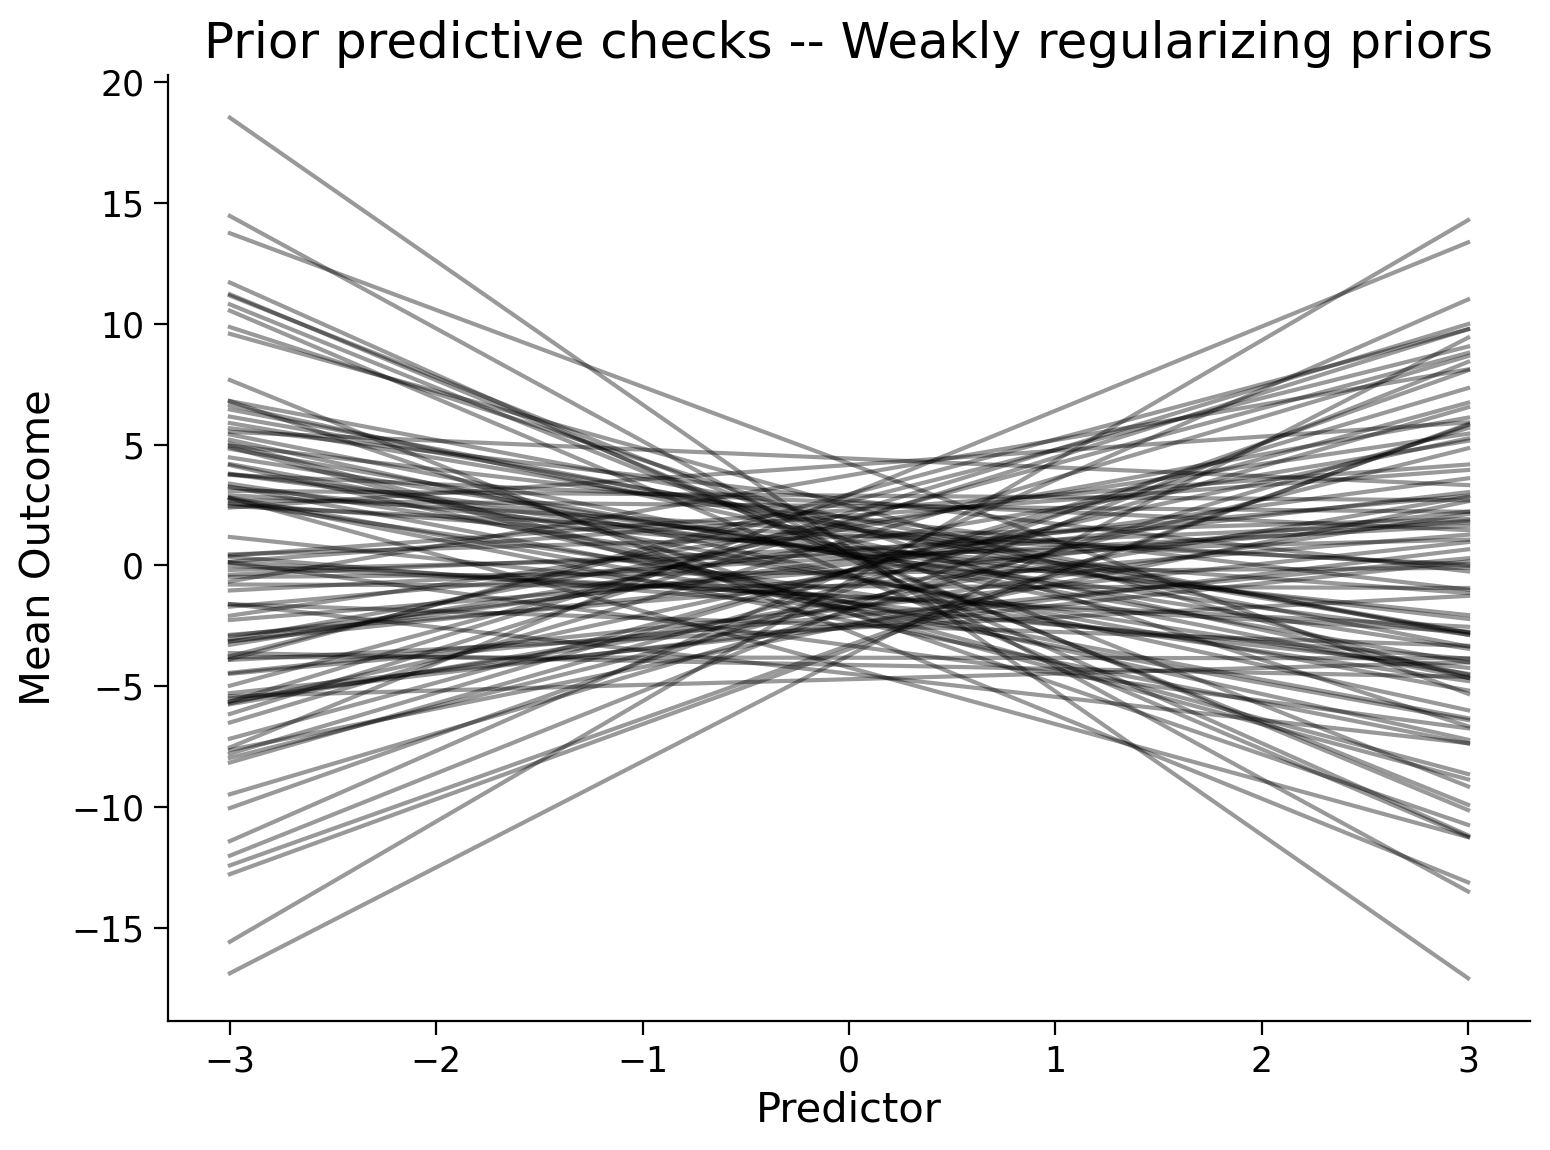

In [22]:
y = prior["alpha"] + prior["beta"] * x
plt.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

plt.xlabel("Predictor")
plt.ylabel("Mean Outcome")
plt.title("Prior predictive checks -- Weakly regularizing priors");

## Distribuzione predittiva a posteriori

Una volta stimata la distribuzione a posteriori, possiamo utilizzarla per generare la distribuzione predittiva a posteriori. Questa distribuzione rappresenta le previsioni del modello che incorporano l'incertezza sui parametri. Per generare la distribuzione predittiva a posteriori, vengono generati $M$ campioni $\{x, y\}$, dove la variabile $x$ è uguale a quella del campione osservato. In ciascun campione, ogni valore $y_i$ per $i=1,\dots,n$ viene generato casualmente dalla distribuzione $\mathcal{N}(\mu = \alpha + \beta \cdot x_i, \sigma)$, dove i valori dei parametri $\alpha$, $\beta$, e $\sigma$ sono campionati dalle rispettive distribuzioni a posteriori. 

In [23]:
with model:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=rng);

Sampling: [y]


Possiamo ora usare la funzione `az.plot_ppc()` per per il posterior predictive check.

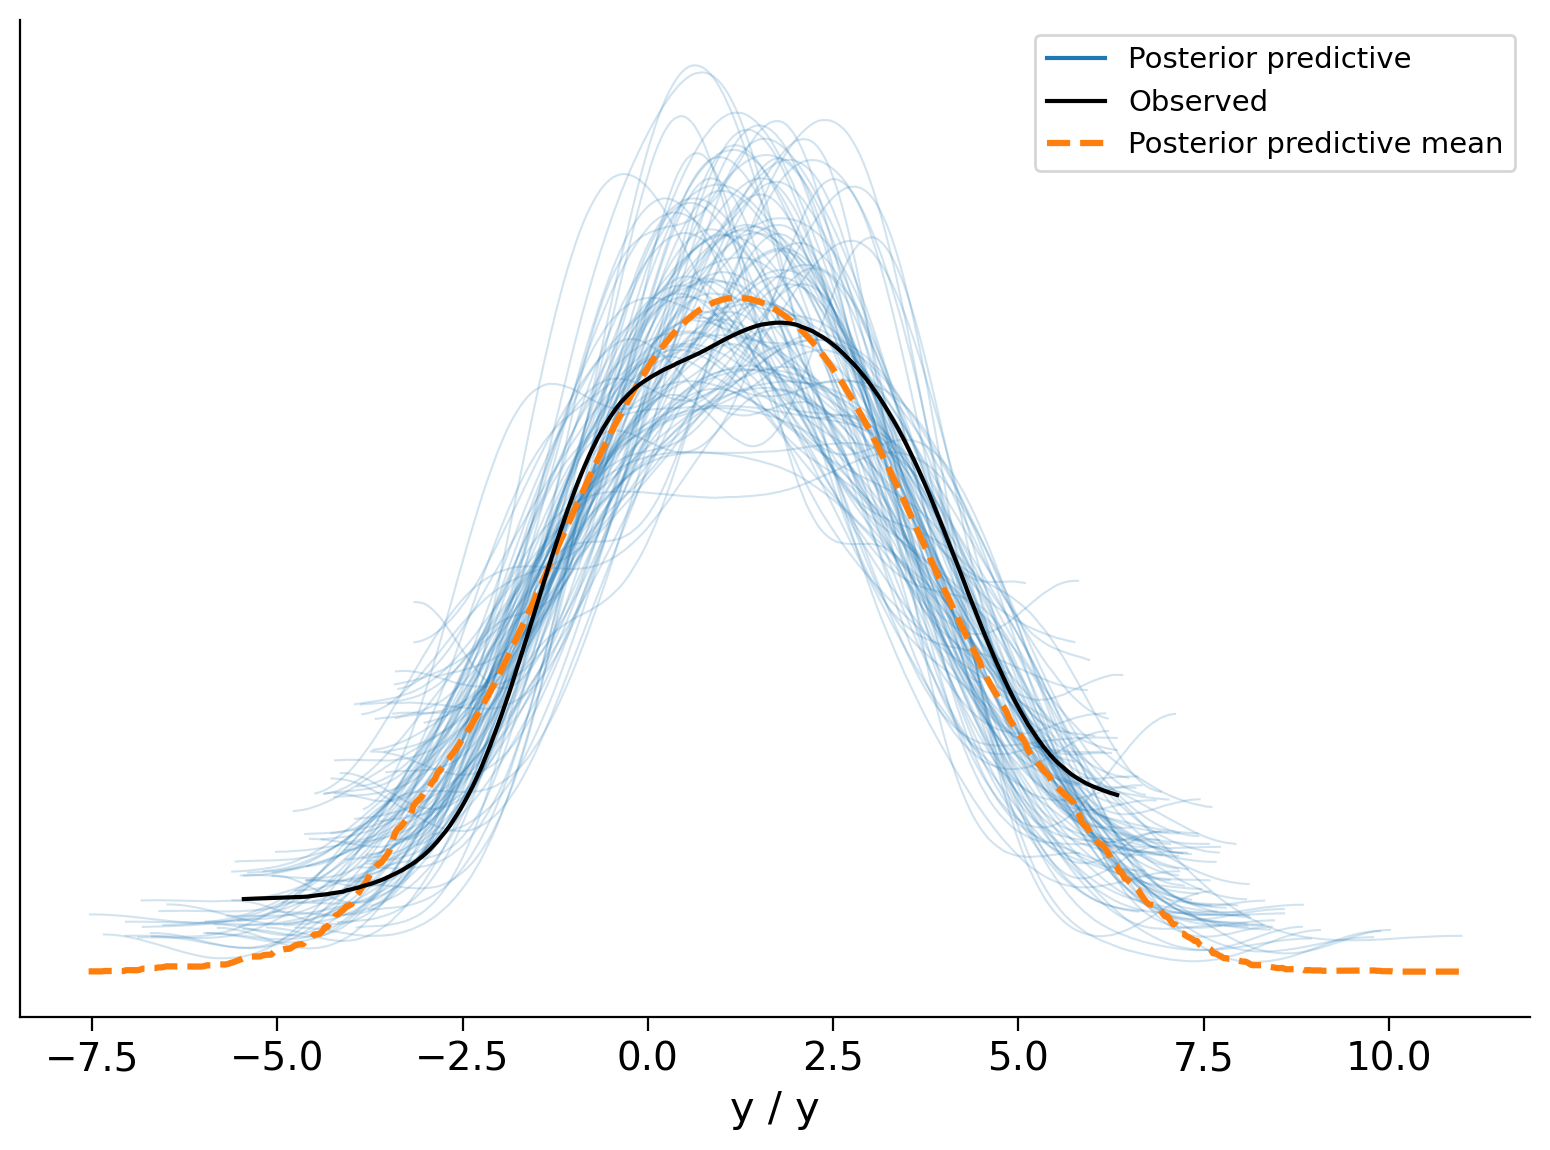

In [24]:
az.plot_ppc(idata, num_pp_samples=100);

La distribuzione predittiva a posteriori può essere utilizzata per valutare la bontà del modello, come mostrato dal grafico prodotto da `az.plot_ppc()`. Le linee blu rappresentano le stime della distribuzione predittiva a posteriori e la linea nera rappresenta i dati osservati. È possibile notare che le previsioni a posteriori sono in linea con i dati osservati in tutta la gamma dei valori della variabile dipendente, indicando che il modello è in grado di fornire previsioni accurate (per un approfondimento, si veda l'appendice {ref}`ppcheck-appendix`).

## Commenti e considerazioni finali

In questo capitolo abbiamo esaminato come stimare i parametri del modello di regressione bivariato tramite l'approccio bayesiano, utilizzando sia PyMC che bambi. Abbiamo osservato come le distribuzioni predittive a priori siano utili per selezionare le distribuzioni a priori dei parametri $\alpha$ e $\beta$ del modello di regressione. Inoltre, abbiamo esaminato come la distribuzione predittiva a posteriori sia utile per valutare l'adattamento del modello ai dati osservati.

Per un confronto con un approccio alternativo, in appendice è fornita un'introduzione alla trattazione frequentista del modello di regressione lineare bivariato. Questa sezione aggiuntiva offre una panoramica degli aspetti chiave dell'approccio frequentista, permettendo così di confrontare e comprendere le differenze tra i due approcci nella stima dei parametri e nell'interpretazione dei risultati.

## Watermark

In [25]:
%watermark -n -u -v -iv 

Last updated: Wed Aug 16 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
seaborn   : 0.12.2
xarray    : 2023.7.0
numpy     : 1.25.2
pandas    : 2.0.3
pymc      : 5.7.2
arviz     : 0.16.1
bambi     : 0.12.0

